# SET UP

### IMPORT PACKAGES AND CONFIGURE SETTINGS

In [1]:
### Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from joblib import dump, load
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from fairlearn.metrics import selection_rate, count
from azureml.core import Workspace, Dataset

warnings.simplefilter(action = "ignore")
ws = Workspace.from_config()

/anaconda/envs/ml_env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
### Plot settings
sns.set(style = "darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
### Create Cramer's V correlation function
def cramers_v(X, Y): 
       confusion_matrix = pd.crosstab(X, Y).to_numpy() 
       chi2 = ss.chi2_contingency(confusion_matrix)[0] 
       n = confusion_matrix.sum()
       phi2 = chi2/n 
       r, k = confusion_matrix.shape 
       phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1)) 
       rcorr = r-((r-1)**2)/(n-1) 
       kcorr = k-((k-1)**2)/(n-1) 
       return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [4]:
### Set seed for reproducibility
rng = np.random.RandomState(123) 

### LOAD AND INSPECT DATA

Dataset is from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/heart+disease

Attribute definition:
- **age**: the individual's age in years
- **sex**: the individual's sex (1 = male, 0 = female)
- **cp**: the chest pain experienced (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
- **trestbps**: the individual's resting blood pressure (mm Hg on admission to the hospital)
- **chol**: the individual's cholesterol measurement in mg/dl
- **fbs**: the individual's fasting blood sugar (> 120 mg/dl, 1 = true, 0 = false)
- **restecg**: the individual's resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach**: the individual's maximum heart rate
- **exang**: exercise induced angina, which is chest pain caused by reduced blood flow to the heart (1 = yes, 0 = no)
- **oldpeak**: ST depression induced by exercise relative to rest (ST relates to positions on the ECG plot)
- **slope**: the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
- **ca**: the number of major vessels
- **thal**: thalassemia, which is an inherited blood disorder (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **heart_disease**: presence of heart diease (1-4 = present, 0 = absent)

In [5]:
col_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
            "exang", "oldpeak", "slope", "ca", "thal", "heart_disease"]
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal", "heart_disease"]

In [6]:
### Load dataset
td_raw = Dataset.get_by_name(ws, "heart_disease_data")
df_raw = td_raw.to_pandas_dataframe()

In [7]:
### Add column names and change data types
df_raw.columns = col_names
for c in cat_cols:
    df_raw[c] = df_raw[c].astype("str")
    df_raw[c] = df_raw[c].astype("category")

In [8]:
# Inspect
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            302 non-null    float64 
 1   sex            302 non-null    category
 2   cp             302 non-null    category
 3   trestbps       302 non-null    float64 
 4   chol           302 non-null    float64 
 5   fbs            302 non-null    category
 6   restecg        302 non-null    category
 7   thalach        302 non-null    float64 
 8   exang          302 non-null    category
 9   oldpeak        302 non-null    float64 
 10  slope          302 non-null    category
 11  ca             302 non-null    category
 12  thal           302 non-null    category
 13  heart_disease  302 non-null    category
dtypes: category(9), float64(5)
memory usage: 16.0 KB
None


In [6]:
# View head
df_raw.head()

age  sex   cp  trestbps   chol  fbs restecg  thalach exang  oldpeak slope  \
0  63.0  1.0  1.0     145.0  233.0  1.0     2.0    150.0   0.0      2.3   3.0   
1  67.0  1.0  4.0     160.0  286.0  0.0     2.0    108.0   1.0      1.5   2.0   
2  67.0  1.0  4.0     120.0  229.0  0.0     2.0    129.0   1.0      2.6   2.0   
3  37.0  1.0  3.0     130.0  250.0  0.0     0.0    187.0   0.0      3.5   3.0   
4  41.0  0.0  2.0     130.0  204.0  0.0     2.0    172.0   0.0      1.4   1.0   

    ca thal heart_disease  
0  0.0  6.0             0  
1  3.0  3.0             2  
2  2.0  7.0             1  
3  0.0  3.0             0  
4  0.0  3.0             0

In [7]:
# View tail
df_raw.tail()

age  sex   cp  trestbps   chol  fbs restecg  thalach exang  oldpeak  \
298  45.0  1.0  1.0     110.0  264.0  0.0     0.0    132.0   0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0     0.0    141.0   0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0     0.0    115.0   1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0     2.0    174.0   0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0     0.0    173.0   0.0      0.0   

    slope   ca thal heart_disease  
298   2.0  0.0  7.0             1  
299   2.0  2.0  7.0             2  
300   2.0  1.0  7.0             3  
301   2.0  1.0  3.0             1  
302   1.0    ?  3.0             0

In [8]:
# View unique column values
for c in df_raw.columns:
    print(c + ": " + str(list(df_raw[c].unique())))

age: [63.0, 67.0, 37.0, 41.0, 56.0, 62.0, 57.0, 53.0, 44.0, 52.0, 48.0, 54.0, 49.0, 64.0, 58.0, 60.0, 50.0, 66.0, 43.0, 40.0, 69.0, 59.0, 42.0, 55.0, 61.0, 65.0, 71.0, 51.0, 46.0, 45.0, 39.0, 68.0, 47.0, 34.0, 35.0, 29.0, 70.0, 77.0, 38.0, 74.0, 76.0]
sex: ['1.0', '0.0']
cp: ['1.0', '4.0', '3.0', '2.0']
trestbps: [145.0, 160.0, 120.0, 130.0, 140.0, 172.0, 150.0, 110.0, 132.0, 117.0, 135.0, 112.0, 105.0, 124.0, 125.0, 142.0, 128.0, 170.0, 155.0, 104.0, 180.0, 138.0, 108.0, 134.0, 122.0, 115.0, 118.0, 100.0, 200.0, 94.0, 165.0, 102.0, 152.0, 101.0, 126.0, 174.0, 148.0, 178.0, 158.0, 192.0, 129.0, 144.0, 123.0, 136.0, 146.0, 106.0, 156.0, 154.0, 114.0, 164.0]
chol: [233.0, 286.0, 229.0, 250.0, 204.0, 236.0, 268.0, 354.0, 254.0, 203.0, 192.0, 294.0, 256.0, 263.0, 199.0, 168.0, 239.0, 275.0, 266.0, 211.0, 283.0, 284.0, 224.0, 206.0, 219.0, 340.0, 226.0, 247.0, 167.0, 230.0, 335.0, 234.0, 177.0, 276.0, 353.0, 243.0, 225.0, 302.0, 212.0, 330.0, 175.0, 417.0, 197.0, 198.0, 290.0, 253.0, 172.0,

In [9]:
### Example records where ca and thal are equal to "?"
df_raw[(df_raw["ca"] == "?") | (df_raw["thal"] == "?")]

age  sex   cp  trestbps   chol  fbs restecg  thalach exang  oldpeak  \
87   53.0  0.0  3.0     128.0  216.0  0.0     2.0    115.0   0.0      0.0   
166  52.0  1.0  3.0     138.0  223.0  0.0     0.0    169.0   0.0      0.0   
192  43.0  1.0  4.0     132.0  247.0  1.0     2.0    143.0   1.0      0.1   
266  52.0  1.0  4.0     128.0  204.0  1.0     0.0    156.0   1.0      1.0   
287  58.0  1.0  2.0     125.0  220.0  0.0     0.0    144.0   0.0      0.4   
302  38.0  1.0  3.0     138.0  175.0  0.0     0.0    173.0   0.0      0.0   

    slope   ca thal heart_disease  
87    1.0  0.0    ?             0  
166   1.0    ?  3.0             0  
192   2.0    ?  7.0             1  
266   2.0  0.0    ?             2  
287   2.0    ?  7.0             0  
302   1.0    ?  3.0             0

# TRANSFORM

In [10]:
### Make a copy of the DataFrame
df = df_raw.copy()

The target variable, heart_diease, currently has 5 unique values. A value of 0 indicates heart disease absence while a values 1-4 indicate heart disease presence. Lets make this a binary classification problem, where 0 means absence and 1 means presence

In [11]:
### Convert heart_diease into a binary variable (absence = 0, presence = 1)
df["heart_disease"] = np.where(df["heart_disease"] == "0", 0, 1)
print(df["heart_disease"].unique())

[0 1]


Variables ca and thal contain records with "?." Let's drop these records since they only make up 2% of the dataset

In [12]:
### Drop ca and thal records equal to "?"
ind_ = df[(df["ca"] == "?") | (df["thal"] == "?")].index
df.drop(index = ind_, inplace = True)

In [13]:
# Check that the records are dropped
df[(df["ca"] == "?") | (df["thal"] == "?")]

Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, heart_disease]
Index: []

In [14]:
### Remove categories
df["ca"] = df["ca"].cat.remove_categories(["?"])
df["thal"] = df["thal"].cat.remove_categories(["?"])
print(df["ca"].cat.categories, df["thal"].cat.categories)

Index(['0.0', '1.0', '2.0', '3.0'], dtype='object') Index(['3.0', '6.0', '7.0'], dtype='object')


# EDA

### DISTRIBUTION

In [16]:
### Check class balance
df.groupby(["heart_disease"])[["heart_disease"]].agg(count = ("heart_disease", "count")).reset_index()

heart_disease  count
0              0    160
1              1    137

In [17]:
### View summary statistics
df.describe()

age    trestbps        chol     thalach     oldpeak  \
count  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088  131.693603  247.350168  149.599327    1.055556   
std      9.049736   17.762806   51.997583   22.941562    1.166123   
min     29.000000   94.000000  126.000000   71.000000    0.000000   
25%     48.000000  120.000000  211.000000  133.000000    0.000000   
50%     56.000000  130.000000  243.000000  153.000000    0.800000   
75%     61.000000  140.000000  276.000000  166.000000    1.600000   
max     77.000000  200.000000  564.000000  202.000000    6.200000   

       heart_disease  
count     297.000000  
mean        0.461279  
std         0.499340  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

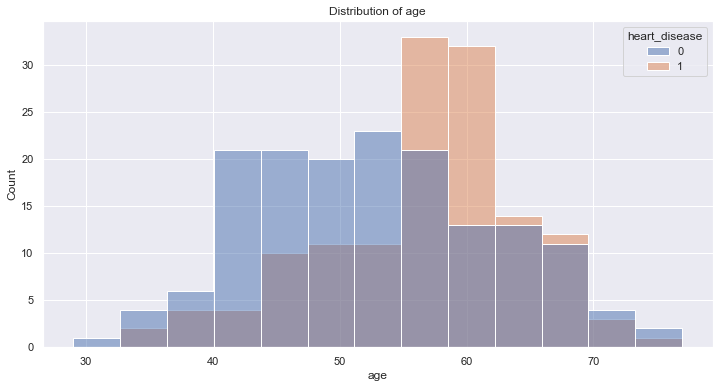

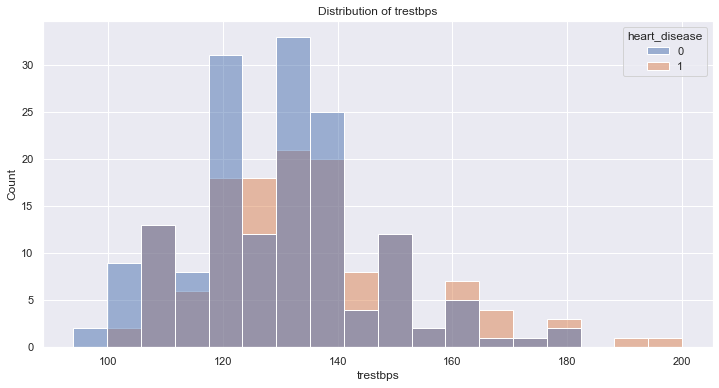

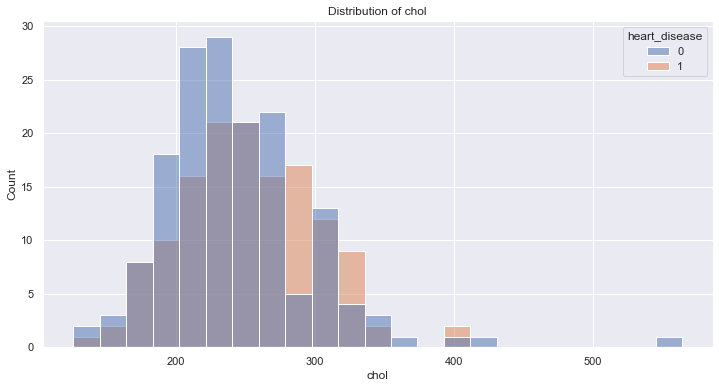

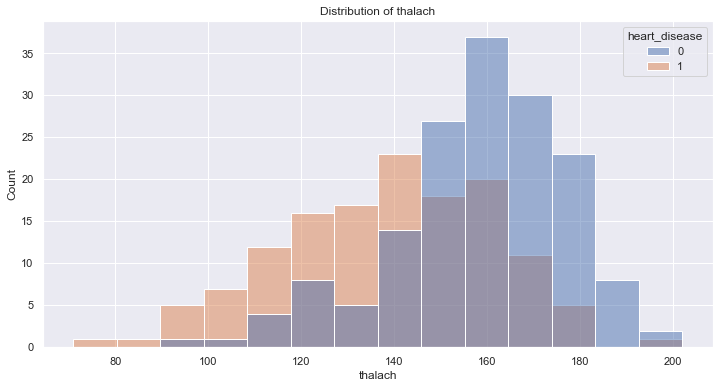

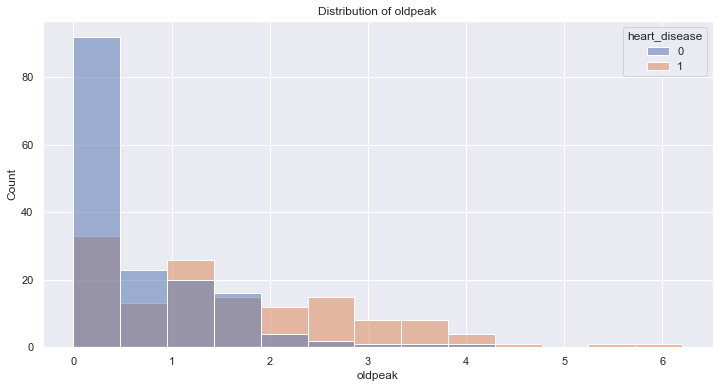

In [18]:
### View distribution of numeric variables
for nc in df.select_dtypes([np.int64, np.float64]).columns:
    sns.histplot(data = df, x = nc, hue = "heart_disease")
    plt.title("Distribution of " + str(nc))
    plt.show()

The above plots highlight there is a higher probability of having heart disease with increasing age, blood pressure, and cholesterol. According to the CDC, a normal blood pressure is less than 120/80 mmHg and a healthy serum cholesterol is less than 200 mg/dL

- https://www.cdc.gov/bloodpressure/about.htm
- https://www.cdc.gov/cholesterol/cholesterol_screening.htm


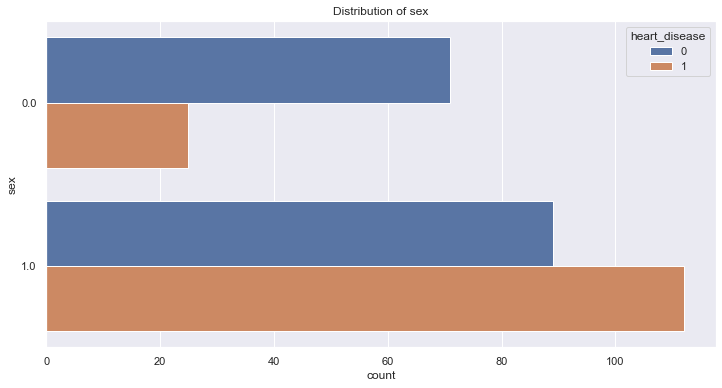

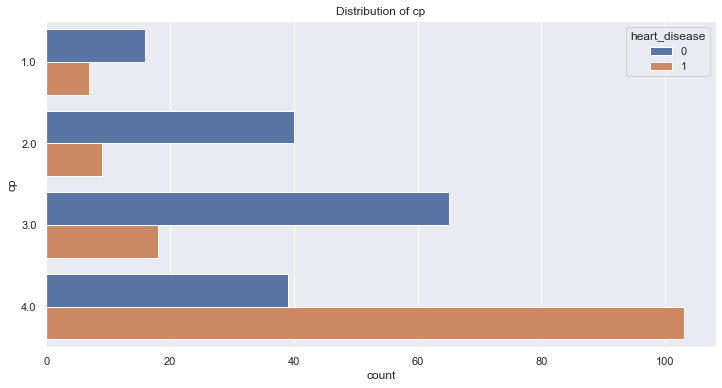

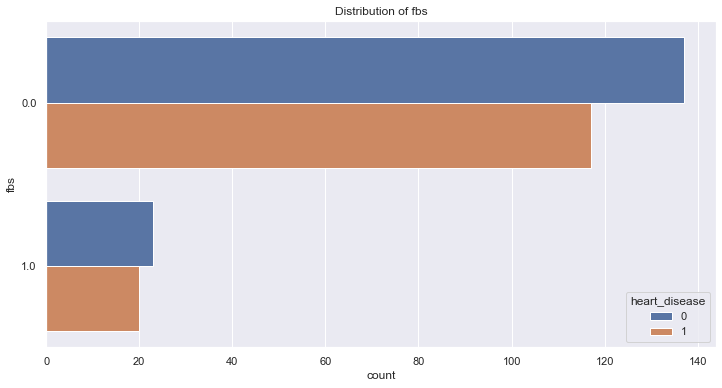

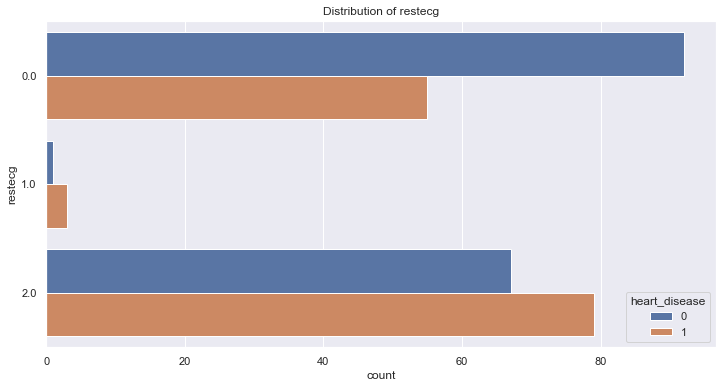

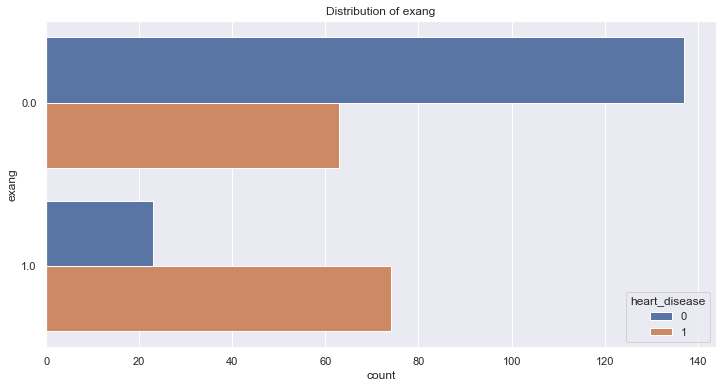

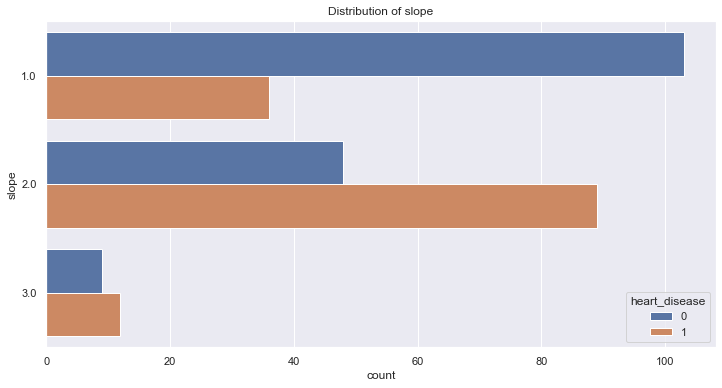

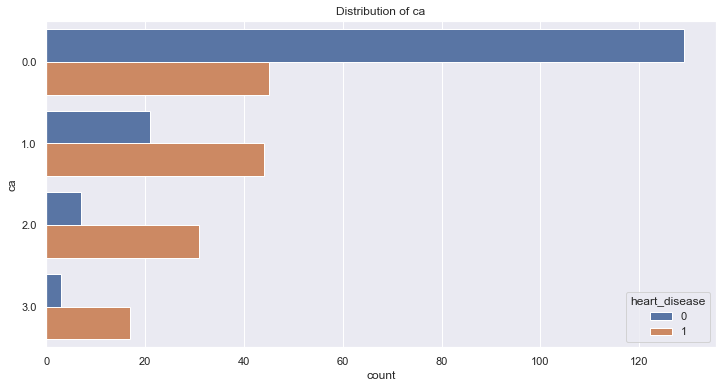

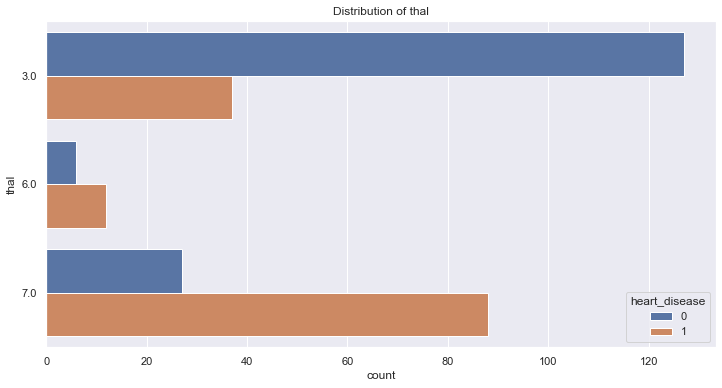

In [19]:
### View distribution of categorical variables
for cc in df.select_dtypes(["category"]).columns:
    sns.countplot(data = df, y = cc, hue = "heart_disease")
    plt.title("Distribution of " + str(cc))
    plt.show()

### CORRELATION

While boosting algorithms are not affected by multicollinearity, it is good practice to check if it exists and remove redundant features

In [20]:
### Correlation of continuous variables
df_con = df.select_dtypes([np.int64, np.float64]).corr()
df_con

age  trestbps      chol   thalach   oldpeak
age       1.000000  0.290476  0.202644 -0.394563  0.197123
trestbps  0.290476  1.000000  0.131536 -0.049108  0.191243
chol      0.202644  0.131536  1.000000 -0.000075  0.038596
thalach  -0.394563 -0.049108 -0.000075  1.000000 -0.347640
oldpeak   0.197123  0.191243  0.038596 -0.347640  1.000000

In [21]:
### Correlation of categorical variables
vars = np.array([])
cors = np.array([])
for c in df.select_dtypes(["category"]).columns:
    for cc in df.select_dtypes(["category"]).columns:
        var = str(c) + "-" + str(cc)
        vars = np.append(vars, var)
        cor = cramers_v(df[c], df[cc])
        cors = np.append(cors, cor)

In [22]:
df_cat = pd.DataFrame(data = np.array([vars, cors]).transpose(), columns = ["Variables", "CramersV"])
df_cat["CramersV"] = df_cat["CramersV"].astype("float")
df_cat[df_cat["CramersV"] >= 0.50]

Variables  CramersV
0           sex-sex  0.992278
9             cp-cp  1.000000
18          fbs-fbs  0.986357
27  restecg-restecg  1.000000
36      exang-exang  0.992319
45      slope-slope  1.000000
54            ca-ca  1.000000
63        thal-thal  1.000000

# TRAIN AND TEST SET

Create two different train and test sets. One set encodes categorical variables while the other one does not. This is to demonstrate CatBoost's handle on categorical variables

In [23]:
df.head()

age  sex   cp  trestbps   chol  fbs restecg  thalach exang  oldpeak slope  \
0  63.0  1.0  1.0     145.0  233.0  1.0     2.0    150.0   0.0      2.3   3.0   
1  67.0  1.0  4.0     160.0  286.0  0.0     2.0    108.0   1.0      1.5   2.0   
2  67.0  1.0  4.0     120.0  229.0  0.0     2.0    129.0   1.0      2.6   2.0   
3  37.0  1.0  3.0     130.0  250.0  0.0     0.0    187.0   0.0      3.5   3.0   
4  41.0  0.0  2.0     130.0  204.0  0.0     2.0    172.0   0.0      1.4   1.0   

    ca thal  heart_disease  
0  0.0  6.0              0  
1  3.0  3.0              1  
2  2.0  7.0              1  
3  0.0  3.0              0  
4  0.0  3.0              0

In [24]:
df_encoded = pd.get_dummies(df, columns = list(df.select_dtypes(["category"]).columns))
df_encoded.head()

age  trestbps   chol  thalach  oldpeak  heart_disease  sex_0.0  sex_1.0  \
0  63.0     145.0  233.0    150.0      2.3              0        0        1   
1  67.0     160.0  286.0    108.0      1.5              1        0        1   
2  67.0     120.0  229.0    129.0      2.6              1        0        1   
3  37.0     130.0  250.0    187.0      3.5              0        0        1   
4  41.0     130.0  204.0    172.0      1.4              0        1        0   

   cp_1.0  cp_2.0  ...  slope_1.0  slope_2.0  slope_3.0  ca_0.0  ca_1.0  \
0       1       0  ...          0          0          1       1       0   
1       0       0  ...          0          1          0       0       0   
2       0       0  ...          0          1          0       0       0   
3       0       0  ...          0          0          1       1       0   
4       0       1  ...          1          0          0       1       0   

   ca_2.0  ca_3.0  thal_3.0  thal_6.0  thal_7.0  
0       0       0         0         1         0  
1       0       1         1         0         0  
2       1       0         0         0         1  
3       0       0         1         0         0  
4       0       0         1         0         0  

[5 rows x 29 columns]

In [25]:
### Identify X and Y
X = df.iloc[:, 0:-1]
X_encoded = df_encoded.loc[:, ~df_encoded.columns.isin(["heart_disease"])]
Y = df.iloc[:, -1]

In [26]:
# Check X
X.head()

age  sex   cp  trestbps   chol  fbs restecg  thalach exang  oldpeak slope  \
0  63.0  1.0  1.0     145.0  233.0  1.0     2.0    150.0   0.0      2.3   3.0   
1  67.0  1.0  4.0     160.0  286.0  0.0     2.0    108.0   1.0      1.5   2.0   
2  67.0  1.0  4.0     120.0  229.0  0.0     2.0    129.0   1.0      2.6   2.0   
3  37.0  1.0  3.0     130.0  250.0  0.0     0.0    187.0   0.0      3.5   3.0   
4  41.0  0.0  2.0     130.0  204.0  0.0     2.0    172.0   0.0      1.4   1.0   

    ca thal  
0  0.0  6.0  
1  3.0  3.0  
2  2.0  7.0  
3  0.0  3.0  
4  0.0  3.0

In [27]:
# Check X_encoded
X_encoded.head()

age  trestbps   chol  thalach  oldpeak  sex_0.0  sex_1.0  cp_1.0  cp_2.0  \
0  63.0     145.0  233.0    150.0      2.3        0        1       1       0   
1  67.0     160.0  286.0    108.0      1.5        0        1       0       0   
2  67.0     120.0  229.0    129.0      2.6        0        1       0       0   
3  37.0     130.0  250.0    187.0      3.5        0        1       0       0   
4  41.0     130.0  204.0    172.0      1.4        1        0       0       1   

   cp_3.0  ...  slope_1.0  slope_2.0  slope_3.0  ca_0.0  ca_1.0  ca_2.0  \
0       0  ...          0          0          1       1       0       0   
1       0  ...          0          1          0       0       0       0   
2       0  ...          0          1          0       0       0       1   
3       1  ...          0          0          1       1       0       0   
4       0  ...          1          0          0       1       0       0   

   ca_3.0  thal_3.0  thal_6.0  thal_7.0  
0       0         0         1         0  
1       1         1         0         0  
2       0         0         0         1  
3       0         1         0         0  
4       0         1         0         0  

[5 rows x 28 columns]

In [28]:
# Check Y
Y.head()

0    0
1    1
2    1
3    0
4    0
Name: heart_disease, dtype: int32

In [29]:
### Create train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.70, stratify = df["heart_disease"], random_state = rng)

In [30]:
# Check Y_train
Y_train.value_counts()

0    112
1     95
Name: heart_disease, dtype: int64

In [31]:
# Check Y_test
Y_test.value_counts()

0    48
1    42
Name: heart_disease, dtype: int64

In [32]:
### Create train and test encoded sets
X_encoded_train, X_encoded_test, Y_encoded_train, Y_encoded_test = train_test_split(X_encoded, Y, train_size = 0.70, stratify = df["heart_disease"], random_state = rng)

In [33]:
# Check Y_encoded_train
Y_encoded_train.value_counts()

0    112
1     95
Name: heart_disease, dtype: int64

In [34]:
# Check Y_encoded_test
Y_encoded_test.value_counts()

0    48
1    42
Name: heart_disease, dtype: int64

# MODEL

The objective of the project is to detect heart disease presence by leveraging boosting algorithms XGBoost, LightGBM, and CatBoost. Peers on Kaggle used a variety of algorithms and achieved a model accuracy in the low to mid-80s. Lets see if this can be achieved

In [35]:
### Cross validation
cv = KFold(n_splits = 10)

### XGBOOST

In [55]:
### Set up estimator and grid parameters
xgb = XGBClassifier(objective = "binary:logistic", booster = "gbtree", use_label_encoder = False, random_state = rng)
xgb_params = {"n_estimators": [100, 200, 300], "learning_rate": [0.10, 0.20], "max_depth": [6, 8, 10], 
                "colsample_bytree": [0.50, 0.75, 1], "reg_alpha": [0, 0.25, 0.50, 0.75, 1], "reg_lambda": [0, 0.25, 0.50, 0.75, 1]}

In [56]:
### Perform grid search
xgb_grid = RandomizedSearchCV(xgb, xgb_params, scoring = "accuracy", n_iter = 20, cv = cv, verbose = 2)
xgb_grid.fit(X_encoded_train, Y_encoded_train, eval_metric = "logloss")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, reg_alpha=0, reg_lambda=0.25; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, reg_alpha=0, reg_lambda=0.25; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, reg_alpha=0, reg_lambda=0.25; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, reg_alpha=0, reg_lambda=0.25; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, reg_alpha=0, reg_lambda=0.25; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, reg_alpha=0, reg_lambda=0.25; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, reg_alpha=0, reg_lambda=0.25; total time=   0.1s
[CV] END colsample_bytree=0

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           m...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False,
             

In [57]:
### View best model's parameters
xgb_grid.best_params_

{'reg_lambda': 0.25,
 'reg_alpha': 0,
 'n_estimators': 200,
 'max_depth': 8,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [58]:
### Save/load model
dump(xgb_grid, "/mnt/batch/tasks/shared/LS_root/mounts/clusters/ml-ci/code/Users/judyxdu/Heart-Disease/Model/xgb_model.pkl")

['C:/Users/Judy/Desktop/Heart-Disease/Model/xgb_model.pkl']

In [59]:
### Get feature importance
df_imp = pd.DataFrame(data = np.array([X_encoded_train.columns, xgb_grid.best_estimator_.feature_importances_]).transpose(),
                        columns = ["Feature", "Feature_Importance"])
df_imp.sort_values(["Feature_Importance"], ascending = False, inplace = True)

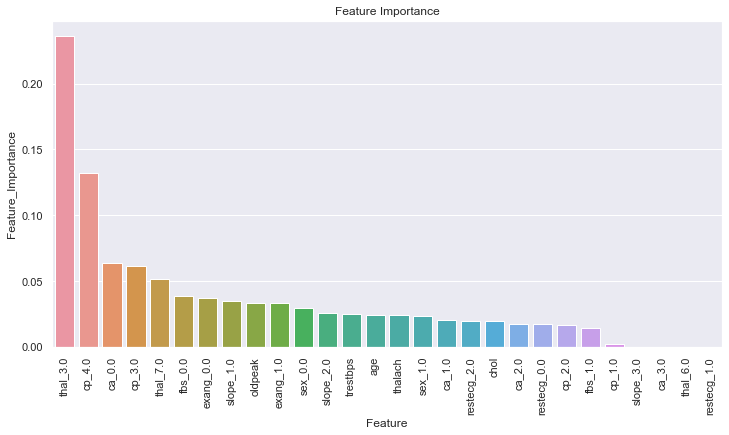

In [60]:
### Plot feature importance
sns.barplot(data = df_imp, x = "Feature", y = "Feature_Importance")
plt.xticks(rotation = 90)
plt.title("Feature Importance")
plt.show()

In [61]:
### Score model
xgb_y_pred = xgb_grid.predict(X_encoded_test)
xgb_y_prob = xgb_grid.predict_proba(X_encoded_test)
y_prob = xgb_y_prob[:, 1]

Text(0.5, 1.0, 'ROC Curve')

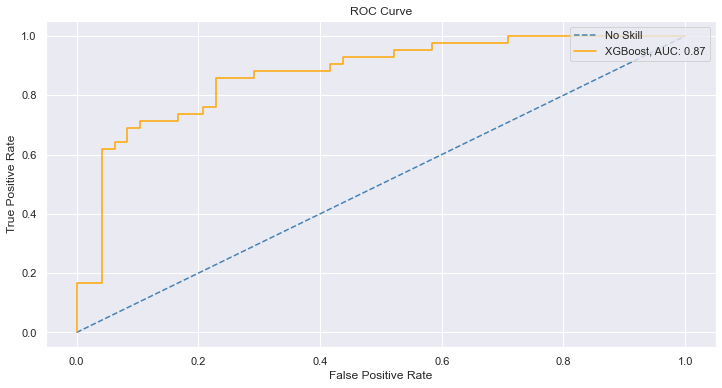

In [62]:
### Plot ROC Curve
auc = round(roc_auc_score(Y_encoded_test, y_prob), 2)
fpr, tpr, _ = roc_curve(Y_encoded_test, y_prob)
plt.plot([0, 1], [0, 1], color = "steelblue", linestyle = "--", label = "No Skill")
plt.plot(fpr, tpr, color = "orange", label = f"XGBoost, AUC: {auc}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "upper right")
plt.title("ROC Curve")

In [63]:
### Print classification report
print(classification_report(Y_encoded_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79        48
           1       0.75      0.79      0.77        42

    accuracy                           0.78        90
   macro avg       0.78      0.78      0.78        90
weighted avg       0.78      0.78      0.78        90



### LIGHTGBM

In [64]:
### Set up estimator and grid parameters
lightgbm = LGBMClassifier(objective = "binary", boosting_type = "goss", random_state = rng)
lightgbm_params = {"n_estimators": [100, 200, 300], "learning_rate": [0.10, 0.20], "max_depth": [6, 8, 10], 
                    "colsample_bytree": [0.50, 0.75, 1], "reg_alpha": [0, 0.50, 1], "reg_lambda": [0, 0.50, 1]}

In [65]:
### Perform grid search
lightgbm_grid = GridSearchCV(lightgbm, lightgbm_params, scoring = "accuracy", cv = cv, verbose = 2)
lightgbm_grid.fit(X_encoded_train, Y_encoded_train, eval_metric = "logloss")

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LGBMClassifier(boosting_type='goss', objective='binary',
                                      random_state=RandomState(MT19937) at 0x19FCA9CC340),
             param_grid={'colsample_bytree': [0.5, 0.75, 1],
                         'learning_rate': [0.1, 0.2], 'max_depth': [6, 8, 10],
                         'n_estimators': [100, 200, 300],
                         'reg_alpha': [0, 0.5, 1], 'reg_lambda': [0, 0.5, 1]},
             scoring='accuracy', verbose=2)

In [66]:
### View best model's parameters
lightgbm_grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 200,
 'reg_alpha': 0.5,
 'reg_lambda': 0}

In [72]:
### Save model
dump(lightgbm_grid, "/mnt/batch/tasks/shared/LS_root/mounts/clusters/ml-ci/code/Users/judyxdu/Heart-Disease/Model/lightgbm_model.pkl")

['lightgbm_model.pkl']

In [67]:
### Get feature importance
df_imp = pd.DataFrame(data = np.array([X_encoded_train.columns, lightgbm_grid.best_estimator_.feature_importances_]).transpose(),
                        columns = ["Feature", "Feature_Importance"])
df_imp.sort_values(["Feature_Importance"], ascending = False, inplace = True)

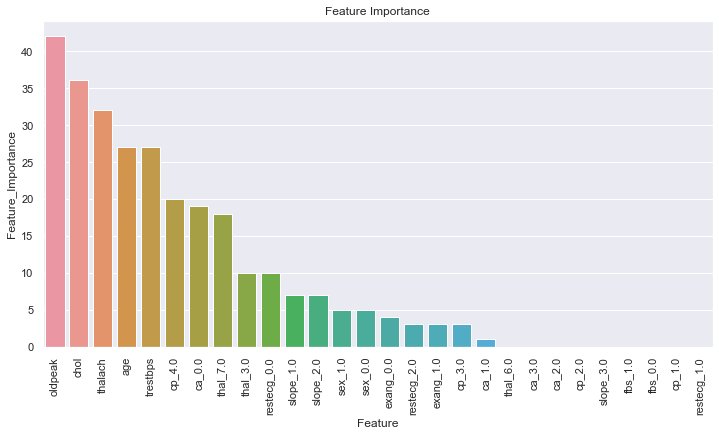

In [68]:
### Plot feature importance
sns.barplot(data = df_imp, x = "Feature", y = "Feature_Importance")
plt.xticks(rotation = 90)
plt.title("Feature Importance")
plt.show()

In [69]:
### Score model
lightgbm_y_pred = lightgbm_grid.predict(X_encoded_test)
lightgbm_y_prob = lightgbm_grid.predict_proba(X_encoded_test)
y_prob = lightgbm_y_prob[:, 1]

Text(0.5, 1.0, 'ROC Curve')

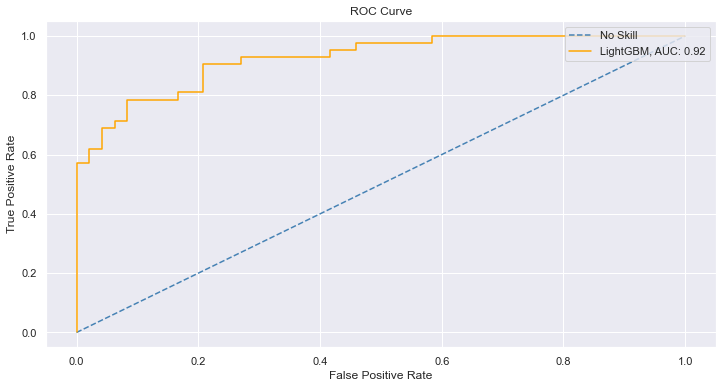

In [70]:
### Plot ROC Curve
auc = round(roc_auc_score(Y_encoded_test, y_prob), 2)
fpr, tpr, _ = roc_curve(Y_encoded_test, y_prob)
plt.plot([0, 1], [0, 1], color = "steelblue", linestyle = "--", label = "No Skill")
plt.plot(fpr, tpr, color = "orange", label = f"LightGBM, AUC: {auc}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "upper right")
plt.title("ROC Curve")

In [71]:
### Print classification report
print(classification_report(Y_encoded_test, lightgbm_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83        48
           1       0.78      0.86      0.82        42

    accuracy                           0.82        90
   macro avg       0.82      0.82      0.82        90
weighted avg       0.83      0.82      0.82        90



### CATBOOST

In [73]:
### Set up estimator and grid parameters
cb = CatBoostClassifier(loss_function = "Logloss", random_state = 123)
cb_params = {"n_estimators": [100, 200, 300], "learning_rate": [0.10, 0.20], "max_depth": [6, 8, 10], 
                "colsample_bylevel": [0.50, 0.75, 1], "l2_leaf_reg": [0, 0.50, 1]}

In [74]:
### Perform grid search
cb_grid = RandomizedSearchCV(cb, cb_params, scoring = "accuracy", n_iter = 20, cv = cv, verbose = 2)
cb_grid.fit(X_train, Y_train, cat_features = [1, 2, 5, 6, 8, 10, 11, 12])

Fitting 10 folds for each of 20 candidates, totalling 200 fits
0:	learn: 0.4872787	total: 163ms	remaining: 48.8s
1:	learn: 0.3874851	total: 362ms	remaining: 54s
2:	learn: 0.2675120	total: 463ms	remaining: 45.8s
3:	learn: 0.2203760	total: 562ms	remaining: 41.6s
4:	learn: 0.1793120	total: 677ms	remaining: 39.9s
5:	learn: 0.1363295	total: 797ms	remaining: 39s
6:	learn: 0.1102717	total: 909ms	remaining: 38s
7:	learn: 0.0939524	total: 1.05s	remaining: 38.4s
8:	learn: 0.0786299	total: 1.16s	remaining: 37.5s
9:	learn: 0.0769515	total: 1.2s	remaining: 34.8s
10:	learn: 0.0666831	total: 1.31s	remaining: 34.4s
11:	learn: 0.0620857	total: 1.43s	remaining: 34.4s
12:	learn: 0.0546048	total: 1.56s	remaining: 34.5s
13:	learn: 0.0481474	total: 1.77s	remaining: 36.1s
14:	learn: 0.0445762	total: 1.89s	remaining: 35.9s
15:	learn: 0.0415023	total: 2.05s	remaining: 36.4s
16:	learn: 0.0383513	total: 2.21s	remaining: 36.7s
17:	learn: 0.0347556	total: 2.36s	remaining: 36.9s
18:	learn: 0.0317077	total: 2.47s	re

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000019FCF4EF1C0>,
                   n_iter=20,
                   param_distributions={'colsample_bylevel': [0.5, 0.75, 1],
                                        'l2_leaf_reg': [0, 0.5, 1],
                                        'learning_rate': [0.1, 0.2],
                                        'max_depth': [6, 8, 10],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy', verbose=2)

In [75]:
### View best model's parameters
cb_grid.best_params_

{'n_estimators': 200,
 'max_depth': 8,
 'learning_rate': 0.1,
 'l2_leaf_reg': 0,
 'colsample_bylevel': 1}

In [36]:
### Save/load model
dump(cb_grid, "/mnt/batch/tasks/shared/LS_root/mounts/clusters/ml-ci/code/Users/judyxdu/Heart-Disease/Model/cb_model.pkl")

In [37]:
### Get feature importance
df_imp = pd.DataFrame(data = np.array([X_train.columns, cb_grid.best_estimator_.get_feature_importance()]).transpose(),
                        columns = ["Feature", "Feature_Importance"])
df_imp.sort_values(["Feature_Importance"], ascending = False, inplace = True)

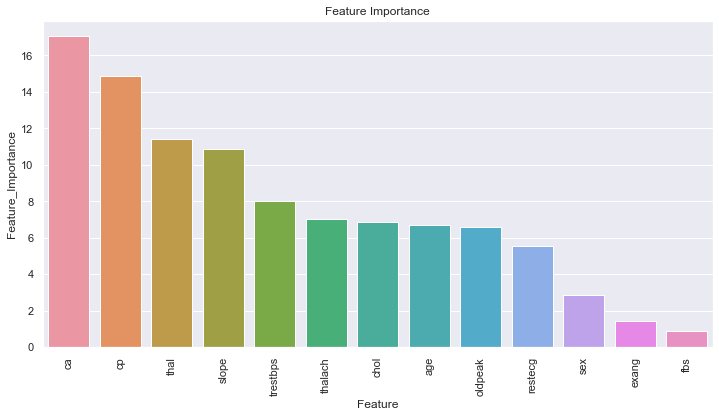

In [38]:
### Plot feature importance
sns.barplot(data = df_imp, x = "Feature", y = "Feature_Importance")
plt.xticks(rotation = 90)
plt.title("Feature Importance")
plt.show()

In [39]:
### Score model
cb_y_pred = cb_grid.predict(X_test)
cb_y_prob = cb_grid.predict_proba(X_test)
y_prob = cb_y_prob[:, 1]

Text(0.5, 1.0, 'ROC Curve')

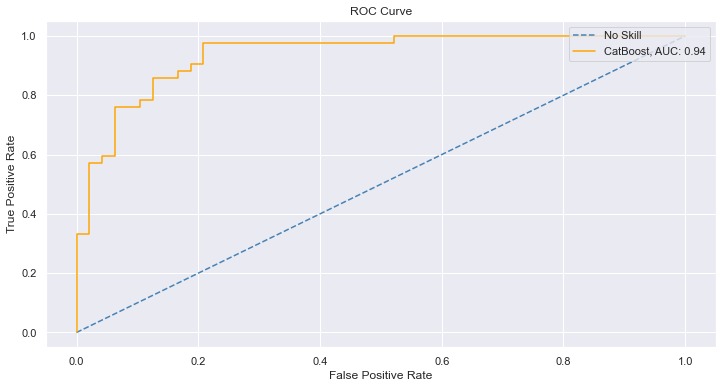

In [40]:
### Plot ROC Curve
auc = round(roc_auc_score(Y_test, y_prob), 2)
fpr, tpr, _ = roc_curve(Y_test, y_prob)
plt.plot([0, 1], [0, 1], color = "steelblue", linestyle = "--", label = "No Skill")
plt.plot(fpr, tpr, color = "orange", label = f"CatBoost, AUC: {auc}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "upper right")
plt.title("ROC Curve")

In [41]:
### Print classification report
print(classification_report(Y_test, cb_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        48
           1       0.81      0.90      0.85        42

    accuracy                           0.86        90
   macro avg       0.86      0.86      0.86        90
weighted avg       0.86      0.86      0.86        90



Catboost outfperformed XGBoost and LightGBM from an AUC, accuracy, recall, precision and f1-score perspective

# MODEL FAIRNESS

Let's check CatBoost's fairness, to ensure the model did not inherit any bias

In [42]:
### Metrics
metrics = {"accuracy": accuracy_score, "precision": precision_score, "recall": recall_score, "f1_score": f1_score, "selection rate": selection_rate, "count": count}

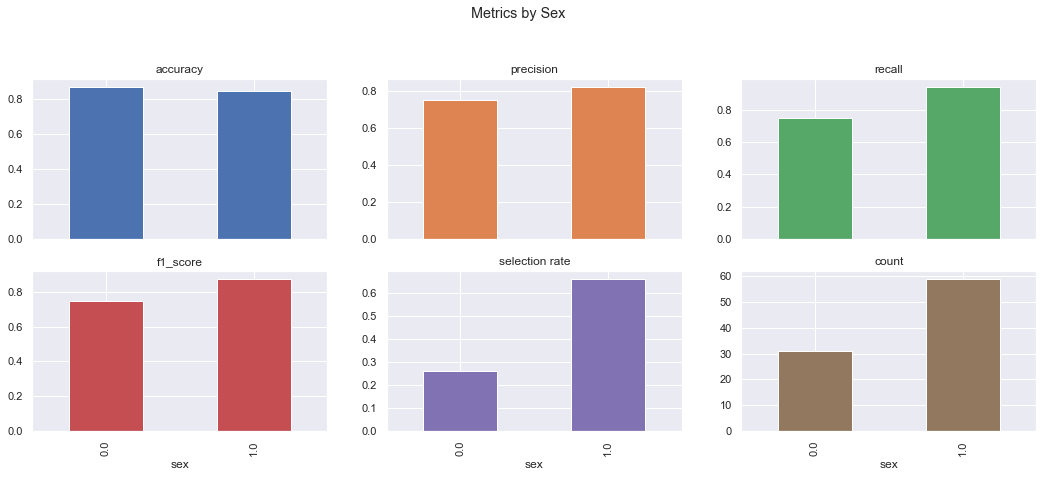

In [48]:
### Plot metrics by sex
metric_frame = MetricFrame(metrics = metrics, y_true = Y_test, y_pred = cb_y_pred, sensitive_features = X_test["sex"])
metric_frame.by_group.plot.bar(subplots = True, layout = [3, 3], legend = False, figsize = [18, 10], title = "Metrics by Sex")
plt.show()

There are more male patients than female patients in the dataset. According to John Hopkins and other similar articles, men are more susceptible to heart disease than women. Because of this, we do see slightly lower metrics in precision, recall, and f1_score for females. One way to tackle this is to add more female patient records. Another is to perform undersampling or oversampling to even out the number of male and female patients

- https://www.hopkinsmedicine.org/health/wellness-and-prevention/special-heart-risks-for-men